## Ucitavanje neophodnih biblioteka

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import matplotlib.pyplot as plt 

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import plot_confusion_matrix, classification_report

nltk.download('stopwords')
nltk.download('wordnet')

pd.options.display.max_colwidth=100

## Ucitavanje podataka i postavljanje labela na osnovu ime fajla u kome se nalaze tekstovi

In [3]:
MAIN_DIR_PATH="./bbc"
texts=[]
labels=[]
for dir_name in os.listdir(MAIN_DIR_PATH):
    path=MAIN_DIR_PATH+'/'+dir_name

    files=[path+'/'+file for file in os.listdir(path)]

    for file in files:
        with open(file) as txt_file:
            texts.append(txt_file.read())
            labels.append(dir_name)

In [4]:
data=pd.DataFrame(zip(texts,labels), columns=['text','label'])
data.head(10)

,text,label
0,Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% t...,business
1,Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in alm...,business
2,Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask ...,business
3,High fuel prices hit BA's profits\n\nBritish Airways has blamed high fuel prices for a 40% drop ...,business
4,Pernod takeover talk lifts Domecq\n\nShares in UK drinks and food firm Allied Domecq have risen ...,business
5,Japan narrowly escapes recession\n\nJapan's economy teetered on the brink of a technical recessi...,business
6,"Jobs growth still slow in the US\n\nThe US created fewer jobs than expected in January, but a fa...",business
7,"India calls for fair trade rules\n\nIndia, which attends the G7 meeting of seven leading industr...",business
8,"Ethiopia's crop production up 24%\n\nEthiopia produced 14.27 million tonnes of crops in 2004, 24...",business
9,Court rejects $280bn tobacco case\n\nA US government claim accusing the country's biggest tobacc...,business


## Broj novinskih clanaka po kategoriji

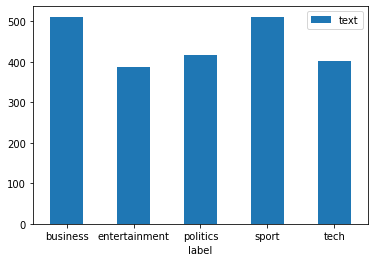

In [5]:
data.groupby('label').count().plot.bar(ylim=0,rot=0)
plt.show()

## Funkcija za preprocesiranje teksta
### - konverzija u mala slova
### - ukljanjanje svih karaktera osim malih slova i podela teksta na reci
### - ukljanjanje stop reci koje se nalaze u recniku stop reci NLTK biblioteke
### - lematizacija

In [6]:
def preprocess_text(original_text):
    text=original_text.lower()
    tokenizer = RegexpTokenizer(r"[a-z]+")
    text=tokenizer.tokenize(text)
    text = [word for word in text if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemm_text=[]
    for word in text:
        lemm_text.append(lemmatizer.lemmatize(word))
    return ' '.join(lemm_text)

In [7]:
data['preprocessed_text']=data.apply(lambda x:preprocess_text(x['text']),axis=1)
data[:10]

,text,label,preprocessed_text
0,Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% t...,business,ad sale boost time warner profit quarterly profit u medium giant timewarner jumped bn three mont...
1,Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in alm...,business,dollar gain greenspan speech dollar hit highest level euro almost three month federal reserve he...
2,Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask ...,business,yukos unit buyer face loan claim owner embattled russian oil giant yukos ask buyer former produc...
3,High fuel prices hit BA's profits\n\nBritish Airways has blamed high fuel prices for a 40% drop ...,business,high fuel price hit ba profit british airway blamed high fuel price drop profit reporting result...
4,Pernod takeover talk lifts Domecq\n\nShares in UK drinks and food firm Allied Domecq have risen ...,business,pernod takeover talk lift domecq share uk drink food firm allied domecq risen speculation could ...
5,Japan narrowly escapes recession\n\nJapan's economy teetered on the brink of a technical recessi...,business,japan narrowly escape recession japan economy teetered brink technical recession three month sep...
6,"Jobs growth still slow in the US\n\nThe US created fewer jobs than expected in January, but a fa...",business,job growth still slow u u created fewer job expected january fall jobseekers pushed unemployment...
7,"India calls for fair trade rules\n\nIndia, which attends the G7 meeting of seven leading industr...",business,india call fair trade rule india attends g meeting seven leading industrialised nation friday un...
8,"Ethiopia's crop production up 24%\n\nEthiopia produced 14.27 million tonnes of crops in 2004, 24...",business,ethiopia crop production ethiopia produced million tonne crop higher average past five year repo...
9,Court rejects $280bn tobacco case\n\nA US government claim accusing the country's biggest tobacc...,business,court reject bn tobacco case u government claim accusing country biggest tobacco company coverin...


## Podela podataka na trening i test skup

In [8]:
X_train,X_test,y_train,y_test=train_test_split(data['preprocessed_text'],data['label'],train_size=0.8, stratify=data['label'])

## Kreiranje TF i TF-IDF vektorizatora sa razlicitim maksimalnim brojem atributa 
### max broj atributa ide od maksimalnog moguceg do 50 

In [9]:
max_features=[20000,10000,5000,1000,500,100,50]
labels=['tf_idf_max','tf_max']
vectorizers=[TfidfVectorizer(),TfidfVectorizer(use_idf=False)]

for max_feature in max_features:
    vectorizers.append(TfidfVectorizer(max_features=max_feature))
    vectorizers.append(TfidfVectorizer(use_idf=False,max_features=max_feature))
    labels.append('tf_idf_'+str(max_feature))
    labels.append('tf_'+str(max_feature))
    

## Treniranje MultinomialNB klasifikatora za svaki vektorizator

In [10]:
acc_scores=[]
classifier = MultinomialNB()

for vectorizer in  vectorizers:
    train_data=vectorizer.fit_transform(X_train)
    test_data=vectorizer.transform(X_test)
    classifier.fit(train_data,y_train)
    acc_scores.append(classifier.score(test_data,y_test)*100)

acc_scores


[96.17977528089887,
 95.0561797752809,
 96.17977528089887,
 95.0561797752809,
 96.17977528089887,
 95.50561797752809,
 96.17977528089887,
 95.73033707865169,
 95.28089887640449,
 95.0561797752809,
 94.83146067415731,
 94.83146067415731,
 87.19101123595505,
 85.84269662921349,
 80.67415730337079,
 81.12359550561797]

## Prikaz tacnosti za sve trenirane klasifikatore

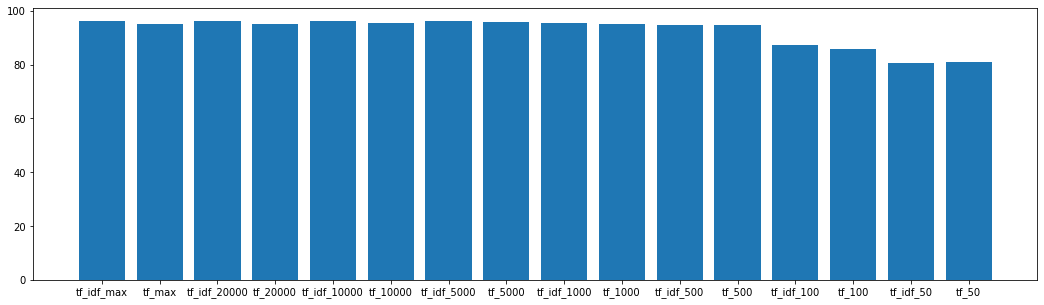

In [11]:
plt.figure(figsize=(18, 5))
plt.bar(labels,acc_scores)
plt.show()

In [12]:
score_df=pd.DataFrame([labels,acc_scores],index=['vectorizer','score']).T
score_df.sort_values(by=['score'],axis=0,ascending=False)

,vectorizer,score
0,tf_idf_max,96.179775
2,tf_idf_20000,96.179775
4,tf_idf_10000,96.179775
6,tf_idf_5000,96.179775
7,tf_5000,95.730337
5,tf_10000,95.505618
8,tf_idf_1000,95.280899
1,tf_max,95.05618
3,tf_20000,95.05618
9,tf_1000,95.05618


## Treniranje ComplementNB klasifikatora za sve vektorizatore

In [13]:
acc_scores2=[]
classifier = ComplementNB()

for vectorizer in  vectorizers:
    train_data=vectorizer.fit_transform(X_train)
    test_data=vectorizer.transform(X_test)
    classifier.fit(train_data,y_train)
    acc_scores2.append(classifier.score(test_data,y_test)*100)

acc_scores2

[97.52808988764045,
 96.17977528089887,
 97.52808988764045,
 96.17977528089887,
 97.30337078651685,
 96.17977528089887,
 97.30337078651685,
 96.17977528089887,
 95.0561797752809,
 95.28089887640449,
 93.93258426966293,
 94.6067415730337,
 85.1685393258427,
 84.26966292134831,
 74.6067415730337,
 75.28089887640449]

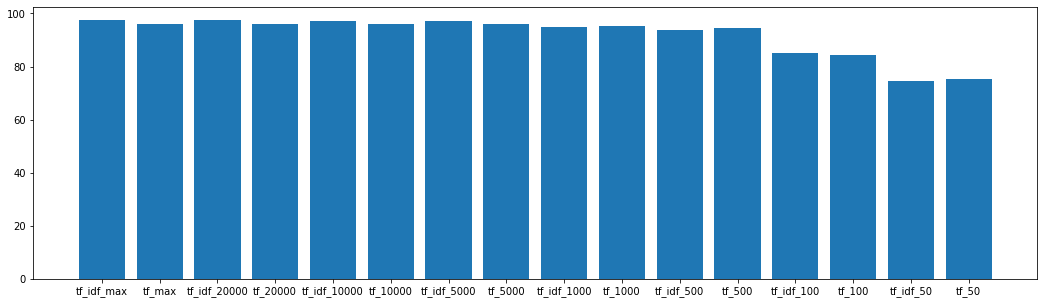

In [14]:
plt.figure(figsize=(18, 5))
plt.bar(labels,acc_scores2)
plt.show()

In [15]:
score_df2=pd.DataFrame([labels,acc_scores2],index=['vectorizer','score']).T
score_df2.sort_values(by=['score'],axis=0,ascending=False)

,vectorizer,score
0,tf_idf_max,97.52809
2,tf_idf_20000,97.52809
4,tf_idf_10000,97.303371
6,tf_idf_5000,97.303371
1,tf_max,96.179775
3,tf_20000,96.179775
5,tf_10000,96.179775
7,tf_5000,96.179775
9,tf_1000,95.280899
8,tf_idf_1000,95.05618


## Konfuziona matrica i klasifikacioni izvestaj za najbolji klasifikator

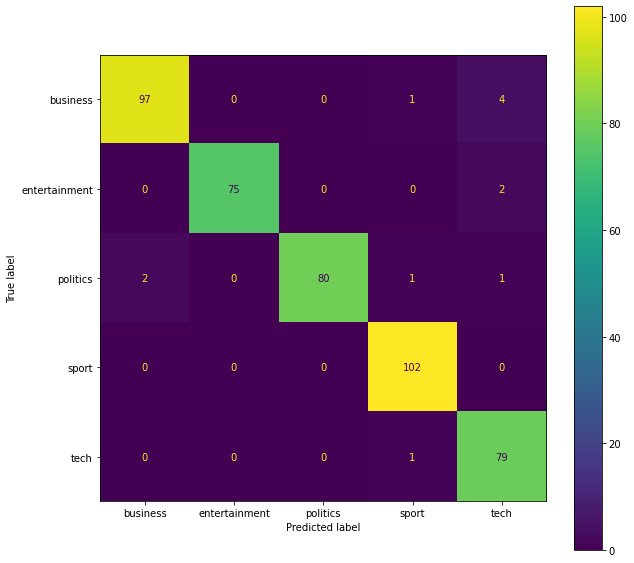

In [16]:
classifier = ComplementNB()
vectorizer=TfidfVectorizer(max_features=10000)

train_data=vectorizer.fit_transform(X_train)
test_data=vectorizer.transform(X_test)
classifier.fit(train_data,y_train)

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(classifier,test_data,y_test,ax=ax)
plt.show()

In [17]:
print(classification_report(y_true=y_test,y_pred=classifier.predict(test_data)))

               precision    recall  f1-score   support

     business       0.98      0.95      0.97       102
entertainment       1.00      0.97      0.99        77
     politics       1.00      0.95      0.98        84
        sport       0.97      1.00      0.99       102
         tech       0.92      0.99      0.95        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



## Prikaz svih pogresno klasifikovanih tekstova

In [18]:
result=pd.DataFrame([X_test]).T

In [19]:
result['true_label']=y_test
result['predicted_label']=classifier.predict(test_data)

In [20]:
result.loc[result['true_label']!=result['predicted_label']]

,preprocessed_text,true_label,predicted_label
780,german music zombie state german music business third largest world state zombie failed respond ...,entertainment,tech
1033,eu fraud clampdown urged eu member state failing report fraud irregularity eu fund consistent ba...,politics,business
19,call centre user lose patience customer trying get call centre getting impatient quicker hang su...,business,tech
2097,world tour top video gamers two uk gamers embark world tour part lucrative ever global game tour...,tech,sport
204,orange colour clash set court row colour orange could hit court mobile phone giant orange launch...,business,tech
971,report attack defence spending ministry defence criticised soaring spending cost growing delay t...,politics,business
657,pupil get anti piracy lesson lesson music piracy copyright issue taught secondary school pupil u...,entertainment,tech
270,arsenal may seek full share listing arsenal vice chairman david dein said club may consider seek...,business,sport
242,making office work mission brighten working life continues time taking long hard look office nex...,business,tech
1073,hatfield executive go trial engineering firm balfour beatty five railway manager go trial mansla...,politics,sport


## Testiranje klasifikatora na slucajno odabranoj vesti koja je iskopirana sa intereneta

In [40]:
test_text="""For all the young dogs waiting for a go at Novak Djokovic, it is increasingly hard to imagine any scenario other than them rolling over for a tickled belly when their moment comes.
There has long been a perceived flimsiness around the next generation of men's tennis, who have spent so much time waiting in line that there is a danger of them missing their turn altogether.
As we begin the second week of Wimbledon, it is necessary to again wonder whether the stasis at the top of the game is down to the astonishing endurance and gifts of a few old boys, or the deficiencies of those in pursuit.
Plainly the answer covers bits of both, but with each passing Slam it is getting harder to mount a defence for younger guys who are suddenly not so young any more.

It is an awkward fact that since Stan Wawrinka won the 2016 US Open, there have been 17 Slams and only one has not been claimed by Djokovic, Rafael Nadal or Federer.
That was Dominic Thiem at last year's US Open, to go with three other finals, but he will turn 28 later this year and is missing these championships with an injury.
Those present and remaining in the draw have a chance across the next week, but it is difficult to make a serious case for anyone beyond Djokovic, irrespective of the Serb not yet looking the full ticket.
Other than his second-round win over Kevin Anderson, in which he was excellent, Djokovic had iffy moments against Jack Draper and Denis Kudla, and his difficult relationship with the Wimbledon crowd is a developing situation.
But for those minor considerations, he remains an overwhelming favourite to take his record-equalling 20th Slam on Sunday.

Even at 34, he is a head, shoulders and most of a torso above the chasing pack, with the next modest barrier to a third straight Wimbledon crown being the 17th seed, Cristian Garin of Chile.
They will play on Centre Court on Monday, where part of the intrigue will concern any further blowouts at those in attendance. 'You know that I play 90 per cent of matches against the audience, the field, the opponents and everyone alive,' said Djokovic.
'It's something I'm used to, but I'm a man of flesh and blood. I can't always stay calm. 'When someone provokes me, when it crosses the line of taste, sportsmanship and respect, then I show him where he belongs.'
Garin, a clay-court specialist with no huge weapon, is part of a curious trend at this tournament, whereby no fewer than 13 of the last 16 are on their best Wimbledon run. Only Djokovic, Federer and Roberto Bautista Agut have gone further, and none of that trio is younger than 33.
"""

test_text=preprocess_text(test_text)
test=vectorizer.transform([test_text])
print(classifier.predict(test))

['sport']
